In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.set_printoptions(precision=9)
np.set_printoptions(suppress=True)


In [2]:
def cross_product(vec1,vec2):
    return np.cross(vec1, vec2)

def norm(vec):
    return np.linalg.norm(vec)

def get_direction_to_center(center, vec):
    return vec - center

def calc_angle(vec1, vec2):
    cross_prod = cross_product(vec1, vec2)
    return np.arctan(cross_prod / norm(cross_prod))

def calculate_rotation_axis(vec1, vec2):
    cross_prod = cross_product(vec1, vec2)
    return(cross_prod / norm(cross_prod))

def create_skew_symmetric_rotation_matrix(rot_axis):
    skew_sym_mat = np.zeros(shape=(3,3))
    x = rot_axis.item(0)
    y = rot_axis.item(1)
    z = rot_axis.item(2)
    skew_sym_mat.itemset((0,0), 0)
    skew_sym_mat.itemset((1,0), z)
    skew_sym_mat.itemset((2,0), -y)
    skew_sym_mat.itemset((0,1), -z)
    skew_sym_mat.itemset((1,1), 0)
    skew_sym_mat.itemset((2,1), x)
    skew_sym_mat.itemset((0,2), y)
    skew_sym_mat.itemset((1,2), -x)
    skew_sym_mat.itemset((0,2), 0)
    #np.array([[0, -k[2], k[1]],[k[2], 0, -k[0]],[-k[1], k[0], 0]])
    skew_sym_mat = np.array([[0, -z, y],[z, 0, -x],[-y, x, 0]])
    return skew_sym_mat
    
def create_simple_rotation_matrix(vec1, vec2):
    axis = cross_product(vec1, vec2)
    axis = axis/norm(axis)
    print(axis)
    angle = np.arccos(np.dot(norm(vec1),norm(axis)))
    print(angle)
    rot_mat = np.zeros(shape=(3,3))
    print(np.sin(angle))
    rcos = np.cos(angle)
    rsin = np.sin(angle)
    u = axis.item(0)
    v = axis.item(1)
    w = axis.item(2)
    
    rot_mat.itemset((0,0), rcos +  u * u * (1- rcos))
    rot_mat.itemset((1,0), w * rsin +  v * u * (1- rcos))
    rot_mat.itemset((2,0), -v *  rsin +  w * u * (1- rcos))
    rot_mat.itemset((0,1), -w * rsin +  u * v * (1- rcos))
    rot_mat.itemset((1,1), rcos +  v * v * (1- rcos))
    rot_mat.itemset((2,1), u * rsin +  w * v * (1- rcos))
    rot_mat.itemset((0,2), v * rsin +  u * w* (1- rcos))
    rot_mat.itemset((1,2), -u * rsin +  v * w * (1- rcos))
    rot_mat.itemset((2,2), rcos +  w * w * (1- rcos))
    
    return rot_mat

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def calculate_theta(actual_tool_direction, desired_tool_direction):
    cross = cross_product(desired_tool_direction, actual_tool_direction)
    cross_norm =norm(cross)
    dot = actual_tool_direction.dot(desired_tool_direction)
    #np.arccos(np.dot(v, vr_desired) / np.linalg.norm(v)*np.linalg.norm(vr_desired))
    #tangens = np.dot(actual_tool_direction, desired_tool_direction) / np.linalg.norm(actual_tool_direction) * np.linalg.norm(desired_tool_direction)
    #tangens = np.arccos(tangens)
    tangens = np.arctan(cross_norm/ dot)
    return tangens

def calculate_rotation_axis(actual_tool_direction, desired_tool_direction):
    #print(actual_tool_direction)
    #print(desired_tool_direction)
    cross = np.cross(actual_tool_direction, desired_tool_direction)
    cross_norm = norm(cross)
    
    return cross/cross_norm

def calculate_desired_orientattion(skew_sym_matrix, theta, actual_rot_matrix):
    identity = np.identity(3)
    print("in calculate desired orientation")
    print(np.sin(theta))
    first_term = identity + skew_sym_matrix * np.sin(theta) + 2 * np.multiply(skew_sym_matrix, skew_sym_matrix)
    print(first_term)
    rot_desired = np.multiply(first_term, actual_rot_matrix)
    return rot_desired
    
def get_tool_direction(troc_point, desired_point):
    return desired_point - troc_point

def look_at(center, target, up):
    f = (center - target)
    f = f/np.linalg.norm(f)
    s = np.cross(f, up)
    s = s/np.linalg.norm(s)

    u = np.cross(s, f)
    u = u/np.linalg.norm(u)

    
    m = np.zeros((3, 3))
    m[0] = s
    m[1] = u
    m[2] = -f

    return m

def calculate_rodriguez_formular_vector_form(current_vector, desired_vector):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector, desired_vector)
    vr_according_to_vector_form = current_vector *np.cos(theta) + (np.cross(rot_axis,current_vector)*np.sin(theta)) + rot_axis*(np.dot(rot_axis, current_vector))*(1.0-np.cos(theta))
    return vr_according_to_vector_form
    
def calculate_rodriguez_formular_matrix_form(current_vector, desired_vector):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector,desired_vector)
    skew_sym_matrix = create_skew_symmetric_rotation_matrix(rot_axis)
    identity = np.eye(3)
    rot_mat = identity + np.sin(theta) * skew_sym_matrix + (1 - np.cos(theta)) * np.matmul(skew_sym_matrix, skew_sym_matrix)
    #rot_mat = identity + skew_sym_mat * np.sin(theta) + 2 * np.matmul(skew_sym_mat, skew_sym_mat) * np.sin(theta/2.0) * np.sin(theta/2.0) 
    return rot_mat
    
def calculate_desired_rotation(current_vector, desired_vector, last_rot_mat):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector, desired_vector)
    skew_sym_mat = create_skew_symmetric_rotation_matrix(rot_axis)
    identity = np.eye(3)
    rot_mat = identity + skew_sym_mat * np.sin(theta) + 2 * np.matmul(skew_sym_mat, skew_sym_mat) * np.sin(theta/2.0) * np.sin(theta/2.0) 
    rot_mat = np.matmul(rot_mat, last_rot_mat)
    return rot_mat

['lol']


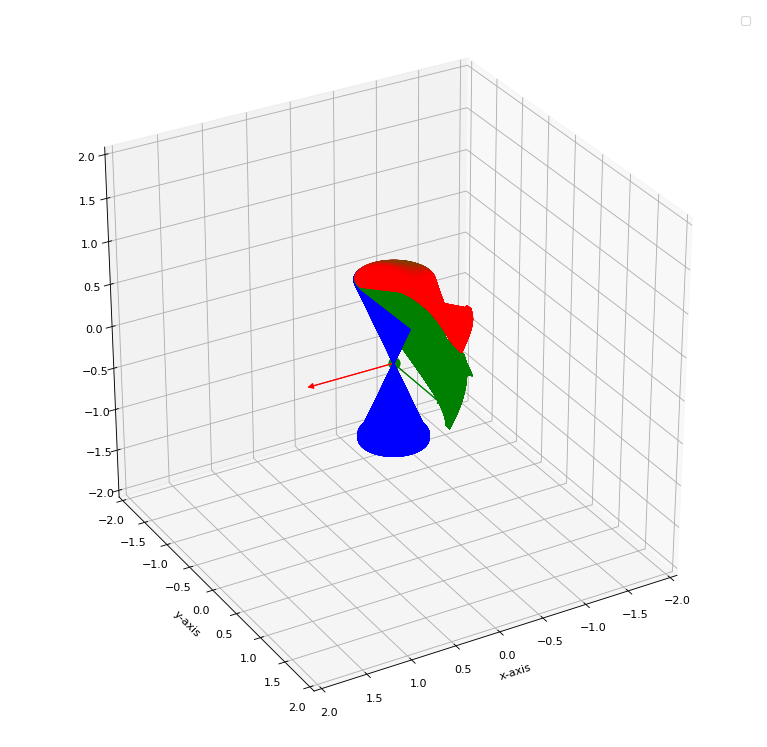

In [27]:
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import proj3d
from matplotlib.pyplot import figure

import pylab

fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)

class Arrow3D(mpatches.FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        mpatches.FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        mpatches.FancyArrowPatch.draw(self, renderer)

#m=float(raw_input())

vector_handles=[]
used_labels=["lol"]

def draw_vector(vec, color, label1):

    a = Arrow3D([vec.item(0),0],[vec.item(1),0],[vec.item(2),0],label=label1, mutation_scale=10, lw=1, arrowstyle="-|>", color=color)
    #b = Arrow3D([vec.item(0),vec.item(0) ],[vec.item(1),vec.item(1) + 1],[vec.item(2),vec.item(2)], mutation_scale=20, lw=1, arrowstyle="-|>", color="g")
    #c = Arrow3D([vec.item(0),vec.item(0) ],[vec.item(1),vec.item(1) ],[vec.item(2),vec.item(2)+1], mutation_scale=20, lw=1, arrowstyle="-|>", color="r")
    #c = Arrow3D([0,0],[0,0],[0,1], mutation_scale=20, lw=1, arrowstyle="-|>", color="b")
    fig.patches.append(a)
    ax.add_artist(a)
    if label1 not in used_labels:
        used_labels.append(label1)
        vector_handles.append(a)
    
    #plt.legend(handles=[a], fontsize=16)
    #plt.legend([a,], ['My label',])
    #ax.legend(a)
    #ax.add_artist(b)
    #ax.add_artist(c)
    return a

def draw_coordinate_system(coord_mat, center):
    x_vec = coord_mat[0]
    y_vec = coord_mat[1] 
    z_vec = coord_mat[2]
    
    x_arrow = Arrow3D([center.item(0),x_vec.item(0)],[center.item(1),x_vec.item(1)],[center.item(2),x_vec.item(2)], mutation_scale=10, lw=1, arrowstyle="-|>", color="red")
    y_arrow = Arrow3D([center.item(0),y_vec.item(0)],[center.item(1),y_vec.item(1)],[center.item(2),y_vec.item(2)], mutation_scale=10, lw=1, arrowstyle="-|>", color="green")
    z_arrow = Arrow3D([center.item(0),z_vec.item(0)],[center.item(1),z_vec.item(1)],[center.item(2),z_vec.item(2)], mutation_scale=10, lw=1, arrowstyle="-|>", color="blue")
    fig.patches.append(x_arrow)
    ax.add_artist(x_arrow)
    fig.patches.append(y_arrow)
    ax.add_artist(y_arrow)
    fig.patches.append(z_arrow)
    ax.add_artist(z_arrow)
    
print(used_labels)
plt.legend(handles=vector_handles)

#def look_at(center, target, up):
#la_center = np.array([1, 1, 1])
#look_at_mat = look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))


number_vectors = 1000
rad = 2 * np.pi / number_vectors
radius = 0.4
vectors = []


for i in range(number_vectors):
    x = np.cos(rad * i) * radius
    y = np.sin(rad * i) * radius
    z = 1.0
    vec = np.array([x,y,z])
    vectors.append(vec)

la_center = np.array([vectors[0].item(0), vectors[0].item(1), vectors[0].item(2)])
look_at_mat = look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))    
draw_coordinate_system(look_at_mat, la_center)    
# for v in vectors:
#         draw_vector(v, "orange", "trajectory points")

curr_vec = vectors[0]
# for v in range(1, len(vectors) - 1):
#     des_vec = vectors[v]
#     #print("desired vecctor = {}".format(des_vec))
#     vr = calculate_rodriguez_formular_vector_form(curr_vec, des_vec)
#     #print("rodriguez vector form result = {}".format(vr))
#     draw_vector(vr/np.linalg.norm(vr), "purple", "calculated points")
#     curr_vec = vr
    
curr_vec = vectors[0]

draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]))

for v in range(1, len(vectors) ):
    
    des_vec = vectors[v]
    #print("desired vecctor = {}".format(des_vec))
    rot_rod = calculate_rodriguez_formular_matrix_form(curr_vec, des_vec)
    #print(rot_rod)
    vr =  np.matmul(rot_rod, curr_vec)
    #print(vr)
    #print(des_vec)
    #print("rodriguez vector form result = {}".format(vr))
    #draw_vector(vr, "red", "rodriguez matrix form points")
    la_center = vr
    #look_at_mat = np.matmul(rot_rod, np.transpose(look_at_mat))
    look_at_mat = np.matmul(look_at_mat, np.transpose(rot_rod))
    #print(vr)
    #print(look_at_mat)
    draw_coordinate_system(look_at_mat, la_center)
    curr_vec = vr

# curr_vec = vectors[0]
# rot_mat_adv = calculate_desired_rotation(curr_vec, des_vec, np.eye(3))#calculate_rodriguez_formular_matrix_form(curr_vec, vectors[1])
# curr_vec = vectors[1]
# for v in range(2, len(vectors) ):
#     des_vec = vectors[v]
#     #print("desired vecctor = {}".format(des_vec))
#     rot_rod_adv = calculate_desired_rotation(curr_vec, des_vec, rot_mat_adv)
#     vr = np.matmul(rot_rod_adv, curr_vec)
#     #print("rodriguez vector form result = {}".format(vr))
#     #draw_vector(vr/np.linalg.norm(vr), "blue", "advanced rodriguez matrix form points")
#     curr_vec = vr
#     la_center = vr
#     look_at_mat = np.matmul(look_at_mat,np.transpose(rot_rod_adv))
#     #look_at_mat = np.matmul(rot_rod_adv,look_at_mat)
#     draw_coordinate_system(look_at_mat, la_center)
#     rot_mat_adv = rot_rod_adv

#ax.legend(handles =vector_handles,loc='upper left')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
ax.view_init(30, 60)
plt.show()

In [4]:
# print("advanced rotation")
# print("v_rot = {}".format(vr_according_to_vector_form))
#print("v_rot = {}".format(vr_according_to_vector_form))
# print("Rotation k:")
# print(k)
#

# center = np.zeros(shape=(1,3))
# center.itemset(1, 1)
# center.itemset(1,0)
# center.itemset(1,1)
# test = np.zeros(shape=(1,3))
# test.itemset(0, 1)
# test.itemset(1, 2)
# test.itemset(2, 3)


# v = np.array([1/3, 1/3, 1/3])**(1/2)
# vr_desired = np.array([1, 0, 0])
# theta = calculate_theta(v, vr_desired)
# k = np.cross(v, vr_desired) / np.linalg.norm(np.cross(v, vr_desired))

# vr_according_to_vector_form = v*np.cos(theta) + (np.cross(k,v)*np.sin(theta)) + k*(np.dot(k,v))*(1.0-np.cos(theta))

# vr_according_to_vector_form = calculate_rodriguez_formular_vector_form(v, vr_desired)

# rot_mat = calculate_rodriguez_formular_matrix_form(v, vr_desired)
# vr_according_to_vector_form = np.matmul(rot_mat, v)



# init_step = np.array([1, 1, 1.9])
# adv_rot_mat = calculate_rodriguez_formular_matrix_form(init_step, v)
# rot_mat_adv = calculate_desired_rotation(v, vr_desired, np.eye(3))
# vr_according_to_vector_form = np.matmul(rot_mat_adv, v)

In [5]:
# from mpl_toolkits.mplot3d import axes3d

# # rotate the axes and update
# for angle in range(0, 360, 30):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     # load some test data for demonstration and plot a wireframe
#     X, Y, Z = axes3d.get_test_data(0.1)
#     ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.1)
#     fig = plt.figure()

In [6]:
import ipyvolume as ipv


first_rot_axis = np.array([0.0, 1.0, 0.0])
vec1 = np.array([1.0, 1.0, 0.0])

test = cross_product(first_rot_axis, vec1)
print(test)
theta = np.arctan(norm(cross_product(first_rot_axis, vec1))/ vec1.dot(first_rot_axis))
print(theta)

# vec2 = np.array([1.5, 1.0, 0.5])
# alpha = np.arccos(vec1.item(0)/norm(vec1))/(np.pi)
# beta = np.arccos(vec1.item(1)/norm(vec1))/(np.pi)
# gamma = np.arccos(vec1.item(2)/norm(vec1))/(np.pi)
# rot_axis = cross_product(vec1, vec2)
# print(alpha)
# print(rot_axis)
# print(norm(rot_axis))

# rot_axis = rot_axis/norm(rot_axis)
# print(rot_axis)

rot_mat = rotation_matrix(first_rot_axis, theta)
print(rot_mat)

vector_rotated = rot_mat.dot(vec1)
print(vector_rotated)

[ 0.  0. -1.]
0.7853981633974483
[[ 0.707106781  0.           0.707106781]
 [ 0.           1.           0.         ]
 [-0.707106781  0.           0.707106781]]
[ 0.707106781  1.          -0.707106781]


In [7]:
x=np.array([1.0,0.5]) 
y= np.array([1.0,0.5]) 
z= np.array([1.0,0.5]) 
u= np.array([-0.6,-0.50]) 
v= np.array([0.23, -0.50]) 
w=np.array([-0.27, 0.50]) 
quiver = ipv.quickquiver(x, y, z, u, v, w, size=5)
ipv.xyzlim(-2,2)
ipv.show()

In [8]:
print(np.random.random((6, 10))*2-1)

[[-0.117836333  0.372072871 -0.147131466  0.173114236  0.004239912
   0.528438895 -0.937015749 -0.315875387  0.296225152  0.329116537]
 [ 0.742599044 -0.436787777 -0.187560855  0.969076462 -0.43984501
  -0.415643614 -0.313393191  0.311991171  0.980869351  0.045635845]
 [ 0.03222909  -0.278422837  0.343527258 -0.502441427 -0.775795649
   0.384245769  0.609088729 -0.537098627 -0.621138651 -0.308925169]
 [-0.888043298 -0.013826849 -0.610589381  0.22578185  -0.407277394
  -0.442621542 -0.099442319 -0.118578267  0.450842619 -0.196933313]
 [ 0.287305375 -0.320481227  0.512493969 -0.465374395 -0.750853268
   0.234975492  0.981137995 -0.777588323  0.461642098  0.359919388]
 [-0.687363188 -0.788369398  0.260495016  0.361109182  0.30731587
  -0.978656642 -0.962475824 -0.602864344  0.755497187  0.674821233]]
